# Importaciones Generales

In [1]:
%cd ~/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters
# %cd D:\CodeProjects\Python\Bayesian-Learning-with-Wasserstein-Barycenters\

/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters


In [2]:
from bwb.distributions import *
from bwb.distributions.data_loaders import *
from bwb.transports import *
from bwb.geodesics import *
from bwb import utils
from bwb import sgdw

## Configuración del Logger

In [3]:
import time
from pathlib import Path


# Whether to clean the logs directory
CLEAN_LOGS = False

# Create the logs directory
LOG_PATH = Path("logs") / f"notebook_{time.strftime('%Y%m%d_%H%M%S')}.log"
if not LOG_PATH.parent.exists():
    LOG_PATH.parent.mkdir()

# Clean the logs
if CLEAN_LOGS:
    for log_file in Path("logs").glob("*.log"):
        log_file.unlink()

In [4]:
import logging
from bwb.logging import log_config


# Remove the handlers
log_config.remove_all_handlers()

# Define and add FileHandler
fh = logging.FileHandler(LOG_PATH)
log_config.set_default_formatter(fh)
log_config.add_handler(fh)


_log = log_config.get_logger("notebook")
log_config.set_level(level=logging.DEBUG, name="notebook")
log_config.set_level(level=logging.INFO, name="bwb.utils")
log_config.set_level(level=logging.DEBUG, name="bwb.sgdw")
log_config.set_level(level=logging.INFO, name="bwb.transports")

# Importar las redes neuronales

In [5]:
from wgan_gp.wgan_gp_vae.model_resnet import Generator, Encoder, LatentDistribution
import torch
from wgan_gp.wgan_gp_vae.utils import load_checkpoint


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NOISE = "norm"
LATENT_DIM = 128
CHANNELS_IMG = 1
NUM_FILTERS = [256, 128, 64, 32]

noise_sampler = LatentDistribution(NOISE, LATENT_DIM, device)

CURR_PATH = Path(".")
NETS_PATH = CURR_PATH / "wgan_gp" / "networks" 

DS_NAME = "data"

G = Generator(LATENT_DIM, CHANNELS_IMG, latent_distr=NOISE).to(device)
E = Encoder(LATENT_DIM, CHANNELS_IMG).to(device)

FACE_PATH = NETS_PATH / f"cleaned_{DS_NAME}_zDim{LATENT_DIM}_{NOISE}_bs_128"

load_checkpoint(G, FACE_PATH, "generator", device)
load_checkpoint(E, FACE_PATH, "encoder", device)

G.eval(); E.eval()
print()

In [6]:
noise_sampler

LatentDistribution(name=norm, z_dim=128, device=cuda)

torch.float64


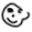

In [7]:
from bwb.distributions import DistributionDraw
from torchvision import disable_beta_transforms_warning
disable_beta_transforms_warning()

import torchvision.transforms.v2 as T


z = noise_sampler(1)
m = G(z)

transform_in = T.Compose([
    T.Lambda(lambda x: x / torch.max(x)),
    T.ToPILImage(),
    T.Resize(32),
    T.ToImageTensor(),
    T.ConvertImageDtype(torch.float32),
    T.Normalize((0.5,), (0.5,)),
])

transform_out = T.Compose([
    T.ToDtype(torch.float64),
    T.Lambda(lambda x: x.squeeze()),
    T.Lambda(lambda x: x - torch.min(x)),
    T.Lambda(lambda x: x / torch.sum(x)),
    T.Lambda(lambda x: DistributionDraw.from_grayscale_weights(x)),
])

out: DistributionDraw = transform_out(m)
print(out.dtype)
out

## Proyector

In [8]:
from wgan_gp.wgan_gp_vae.utils import ProjectorOnManifold
import torchvision.transforms as T

transform_in_proj = T.Compose([
    # From pdf to grayscale
    T.Lambda(lambda x: x / torch.max(x)),
    T.ToPILImage(),
    T.Resize((32, 32)),
    T.ToTensor(),
    T.Normalize(
        [0.5 for _ in range(1)],
        [0.5 for _ in range(1)],
    ),
])

transform_out_proj = T.Compose([
    # Ensure the range is in [0, 1]
    T.Lambda(lambda x: x - torch.min(x)),
    T.Lambda(lambda x: x / torch.max(x)),
    T.Lambda(lambda x: x / torch.sum(x)),
    T.Lambda(lambda x: x.squeeze(0)),
])

proj = ProjectorOnManifold(
    E, G, 
    transform_in=transform_in_proj,
    transform_out=transform_out_proj,
)

## Obtener Dataset

In [9]:
import multiprocessing as mp
from bwb.config import config
from torch.utils.data import DataLoader
from bwb.utils import _ArrayLike
import bwb.distributions as dist

class DatasetWrapper:
    def __init__(self, dataset, dataloader_args=None, device=None, dtype=None, eps=None):
        self.dataset = dataset

        self.dataloader_args = dataloader_args or dict()
        default_args = dict(batch_size=1024, shuffle=False, num_workers=mp.cpu_count())
        for key, value in default_args.items():
            self.dataloader_args.setdefault(key, value)

        self.device = torch.device(device or config.device)
        # If we are working in cuda
        if self.device.type == "cuda":
            self.dataloader_args.setdefault("pin_memory", True)

        self.dtype = dtype or config.dtype

        self.eps = eps or config.eps

    def __len__(self):
        return len(self.dataset)

    def compute_likelihood(self, data: _ArrayLike, **kwargs) -> torch.Tensor:
        dataloader = DataLoader(self.dataset, **self.dataloader_args)
        data = torch.as_tensor(data, device=self.device).reshape(1, -1)

        likelihoods = []

        for features, _ in dataloader:
            # Transfer the features to the appropriate device
            features = torch.as_tensor(features, device=self.device, dtype=self.dtype)
            # Flatten the features
            features = features.reshape(features.size(0), -1)
            # Normalize the features
            features = features / features.sum(dim=1, keepdim=True)
            # Compute the log of the features
            features = torch.log(features + self.eps)
            # Compute the likelihood
            evaluations = torch.take_along_dim(features, data, 1)
            likelihood = torch.exp(evaluations.sum(dim=1))

            likelihoods.append(likelihood)

        likelihood_cache = torch.cat(likelihoods, dim=0)

        probabilities = likelihood_cache / (likelihood_cache.sum() + self.eps)

        return probabilities
    
    def get(self, i: int, **kwargs) -> dist.DistributionDraw:
        return dist.DistributionDraw.from_grayscale_weights(self.dataset[i][0])

In [10]:
import quick_torch as qt

def get_ds(file_path, transform):
    categories = [qt.Category.FACE]
    dataset_ = qt.QuickDraw(
        root="dataset",
        categories=categories,
        transform=transform,
        download=True,
        recognized=True,
    )
    print(len(dataset_))
    path_dataset = Path(file_path)
    dataset_.data = np.load(path_dataset).reshape(-1, 28, 28)
    dataset_.targets = np.ones(len(dataset_.data), dtype=int)
    dataset = dataset_.get_train_data()
    len(dataset)

    return DatasetWrapper(dataset)

transform_ds = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
    T.Lambda(lambda x: x.squeeze()),
])

## CTES

In [11]:
REPORT_EVERY = 100
MAX_ITER = 20_000
MAX_IMGS = 22 * 4
# MAX_ITER = MAX_IMGS

## Definir $\gamma_k$

Aquí se utiliza una función de la forma
\begin{equation*}
    \gamma_k = \frac{a}{(b^{1/c} + k)^c}
\end{equation*}

Con $a > 0$, $b \geq 0$ y $0.5 < c \leq 1$

La idea es que cuando $k=0$, $\gamma_0 = \frac{a}{b}$ es la proporción entre $a$ y $b$, permitiendo ajustar el valor inicial.

In [12]:
from bwb.sgdw import Gamma
window = 3

def test_gamma(gamma):

    for t in range(window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 300
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 500
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 1_000
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 3_000
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 10_000
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 20_000
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 50_000
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 100_000
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")


_a = 4
params = dict(a=_a, b=_a+1e-2, c=0.5+1e-5)
# params = dict(a=1, b=1, c=1)

gamma = Gamma(**params)

test_gamma(Gamma(**params))

t = 0; gamma(t) = 99.75%
t = 1; gamma(t) = 96.79%
t = 2; gamma(t) = 94.07%

t = 300; gamma(t) = 22.50%
t = 301; gamma(t) = 22.46%
t = 302; gamma(t) = 22.43%

t = 500; gamma(t) = 17.61%
t = 501; gamma(t) = 17.59%
t = 502; gamma(t) = 17.57%

t = 1_000; gamma(t) = 12.55%
t = 1_001; gamma(t) = 12.54%
t = 1_002; gamma(t) = 12.54%

t = 3_000; gamma(t) = 7.28%
t = 3_001; gamma(t) = 7.28%
t = 3_002; gamma(t) = 7.28%

t = 10_000; gamma(t) = 4.00%
t = 10_001; gamma(t) = 4.00%
t = 10_002; gamma(t) = 4.00%

t = 20_000; gamma(t) = 2.83%
t = 20_001; gamma(t) = 2.83%
t = 20_002; gamma(t) = 2.83%

t = 50_000; gamma(t) = 1.79%
t = 50_001; gamma(t) = 1.79%
t = 50_002; gamma(t) = 1.79%

t = 100_000; gamma(t) = 1.26%
t = 100_001; gamma(t) = 1.26%
t = 100_002; gamma(t) = 1.26%


# Variedad de caritas 1: Caras normales

## Baricentro de la red

### Versión sin proyectar

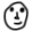

In [13]:
DS_NAME = "data"

G = Generator(LATENT_DIM, CHANNELS_IMG, latent_distr=NOISE).to(device)
E = Encoder(LATENT_DIM, CHANNELS_IMG).to(device)

FACE_PATH = NETS_PATH / f"cleaned_{DS_NAME}_zDim{LATENT_DIM}_{NOISE}_bs_128"

load_checkpoint(G, FACE_PATH, "generator", device)
load_checkpoint(E, FACE_PATH, "encoder", device)

G.eval(); E.eval()

pi_n: GeneratorDistribSampler[DistributionDraw] = GeneratorDistribSampler()
pi_n.fit(generator=G, noise_sampler=noise_sampler, transform_out=transform_out)
pi_n.draw()

In [14]:
dist_draw_sgdw = sgdw.DebiesedDistributionDrawSGDW(
    distr_sampler=pi_n,
    learning_rate=Gamma(**params),
    max_iter=MAX_ITER,
    report_every=REPORT_EVERY,
).set_geodesic_params(
    reg=1e-2,
    stopThr=1e-3,
)
dist_draw_sgdw.det_params, dist_draw_sgdw.hist

(DetentionParameters(tol=0.00e+00, max_iter=20_000, max_time=∞),
 History(pos_wgt=False, distr=False, distr_samp=False, len=0))

In [15]:
_log.info(f"Running SGD-Wasserstein with {DS_NAME} GAN bar. without proj.")
bar, hist = dist_draw_sgdw.run(
    distr_hist=True,
    distr_samp_hist=True,
    include_time=True,
)

In [ ]:
bar

In [ ]:
utils.plot_list_of_draws(hist.distr, max_images=MAX_IMGS)
utils.plot_list_of_draws([x[0] for x in hist.distr_samp], max_images=MAX_IMGS)

In [ ]:
utils.plot_list_of_draws(hist.distr[-MAX_IMGS:], max_images=MAX_IMGS)
utils.plot_list_of_draws([x[0] for x in hist.distr_samp[-MAX_IMGS:]], max_images=MAX_IMGS)

### Versión proyectada

In [ ]:
proj = ProjectorOnManifold(
    E, G, 
    transform_in=transform_in_proj,
    transform_out=transform_out_proj,
)

In [ ]:
face = pi_n.draw()
face

In [ ]:
DistributionDraw.from_grayscale_weights(proj(face.grayscale_weights))

In [ ]:
dist_draw_sgdw = sgdw.DebiesedDistributionDrawSGDW(
    distr_sampler=pi_n,
    projector=proj,
    learning_rate=Gamma(**params),
    max_iter=MAX_ITER,
    report_every=REPORT_EVERY,
).set_geodesic_params(
    reg=1e-2,
    stopThr=1e-3,
)
dist_draw_sgdw.det_params, dist_draw_sgdw.hist

In [ ]:
_log.info(f"Running SGD-Wasserstein with {DS_NAME} GAN bar. with proj.")
bar, hist = dist_draw_sgdw.run(
    distr_hist=True,
    distr_samp_hist=True,
    include_time=True,
)

In [ ]:
bar

In [ ]:
utils.plot_list_of_draws(hist.distr, max_images=MAX_IMGS)
utils.plot_list_of_draws([x[0] for x in hist.distr_samp], max_images=MAX_IMGS)

## Baricentro de las imágenes

### Versión sin proyectar

In [ ]:
DS_PATH = Path("./wgan_gp/dataset") / "cleaned" / f"{DS_NAME}.npy"
models = get_ds(DS_PATH, transform_ds)
models.get(1)

In [ ]:
pi_n: UniformDiscreteSampler[DistributionDraw] = UniformDiscreteSampler().fit(models=models)
pi_n.draw()

In [ ]:
dist_draw_sgdw = sgdw.DebiesedDistributionDrawSGDW(
    distr_sampler=pi_n,
    learning_rate=Gamma(**params),
    max_iter=MAX_ITER,
    report_every=REPORT_EVERY,
).set_geodesic_params(
    reg=1e-2,
    stopThr=1e-3,
)
dist_draw_sgdw.det_params, dist_draw_sgdw.hist

In [ ]:
_log.info(f"Running SGD-Wasserstein with {DS_NAME} DS bar. without proj.")
bar, hist = dist_draw_sgdw.run(
    distr_hist=True,
    distr_samp_hist=True,
    include_time=True,
)

In [ ]:
bar

In [ ]:
utils.plot_list_of_draws(hist.distr, max_images=MAX_IMGS)
utils.plot_list_of_draws([x[0] for x in hist.distr_samp], max_images=MAX_IMGS)

In [ ]:
utils.plot_list_of_draws(hist.distr[-MAX_IMGS:], max_images=MAX_IMGS)
utils.plot_list_of_draws([x[0] for x in hist.distr_samp[-MAX_IMGS:]], max_images=MAX_IMGS)

### Versión Proyectada

In [ ]:
proj = ProjectorOnManifold(
    E, G, 
    transform_in=transform_in_proj,
    transform_out=transform_out_proj,
)

In [ ]:
face = pi_n.draw()
face

In [ ]:
DistributionDraw.from_grayscale_weights(proj(face.grayscale_weights))

In [ ]:
dist_draw_sgdw = sgdw.DebiesedDistributionDrawSGDW(
    distr_sampler=pi_n,
    projector=proj,
    learning_rate=Gamma(**params),
    max_iter=MAX_ITER,
    report_every=REPORT_EVERY,
).set_geodesic_params(
    reg=1e-2,
    stopThr=1e-3,
)
dist_draw_sgdw.det_params, dist_draw_sgdw.hist

In [ ]:
_log.info(f"Running SGD-Wasserstein with {DS_NAME} DS bar. with proj.")
bar, hist = dist_draw_sgdw.run(
    distr_hist=True,
    distr_samp_hist=True,
    include_time=True,
)

In [ ]:
bar

In [ ]:
utils.plot_list_of_draws(hist.distr, max_images=MAX_IMGS)
utils.plot_list_of_draws([x[0] for x in hist.distr_samp], max_images=MAX_IMGS)

---

Hasta aquí termina!

# Variedad de caritas 2: Caras sin contorno

## Baricentro de la red

### Versión sin proyectar

In [ ]:
DS_NAME = "data_sin_contorno"

G = Generator(LATENT_DIM, CHANNELS_IMG, latent_distr=NOISE).to(device)
E = Encoder(LATENT_DIM, CHANNELS_IMG).to(device)

FACE_PATH = NETS_PATH / f"cleaned_{DS_NAME}_zDim{LATENT_DIM}_{NOISE}_bs_128"

load_checkpoint(G, FACE_PATH, "generator", device)
load_checkpoint(E, FACE_PATH, "encoder", device)

G.eval(); E.eval()

pi_n: GeneratorDistribSampler[DistributionDraw] = GeneratorDistribSampler()
pi_n.fit(generator=G, noise_sampler=noise_sampler, transform_out=transform_out)
pi_n.draw()

In [ ]:
dist_draw_sgdw = sgdw.DebiesedDistributionDrawSGDW(
    distr_sampler=pi_n,
    learning_rate=Gamma(**params),
    max_iter=MAX_ITER,
    report_every=REPORT_EVERY,
).set_geodesic_params(
    reg=1e-2,
    stopThr=1e-3,
)
dist_draw_sgdw.det_params, dist_draw_sgdw.hist

In [ ]:
_log.info(f"Running SGD-Wasserstein with {DS_NAME} GAN bar. without proj.")
bar, hist = dist_draw_sgdw.run(
    distr_hist=True,
    distr_samp_hist=True,
    include_time=True,
)

In [ ]:
bar

In [ ]:
utils.plot_list_of_draws(hist.distr, max_images=MAX_IMGS)
utils.plot_list_of_draws([x[0] for x in hist.distr_samp], max_images=MAX_IMGS)

In [ ]:
utils.plot_list_of_draws(hist.distr[-MAX_IMGS:], max_images=MAX_IMGS)
utils.plot_list_of_draws([x[0] for x in hist.distr_samp[-MAX_IMGS:]], max_images=MAX_IMGS)

### Versión proyectada

In [ ]:
proj = ProjectorOnManifold(
    E, G, 
    transform_in=transform_in_proj,
    transform_out=transform_out_proj,
)

In [ ]:
face = pi_n.draw()
face

In [ ]:
DistributionDraw.from_grayscale_weights(proj(face.grayscale_weights))

In [ ]:
dist_draw_sgdw = sgdw.DebiesedDistributionDrawSGDW(
    distr_sampler=pi_n,
    projector=proj,
    learning_rate=Gamma(**params),
    max_iter=MAX_ITER,
    report_every=REPORT_EVERY,
).set_geodesic_params(
    reg=1e-2,
    stopThr=1e-3,
)
dist_draw_sgdw.det_params, dist_draw_sgdw.hist

In [ ]:
_log.info(f"Running SGD-Wasserstein with {DS_NAME} GAN bar. with proj.")
bar, hist = dist_draw_sgdw.run(
    distr_hist=True,
    distr_samp_hist=True,
    include_time=True,
)

In [ ]:
bar

In [ ]:
utils.plot_list_of_draws(hist.distr, max_images=MAX_IMGS)
utils.plot_list_of_draws([x[0] for x in hist.distr_samp], max_images=MAX_IMGS)

## Baricentro de las imágenes

### Versión sin proyectar

In [ ]:
DS_PATH = Path("./wgan_gp/dataset") / "cleaned" / f"{DS_NAME}.npy"
models = get_ds(DS_PATH, transform_ds)
models.get(1)

In [ ]:
pi_n: UniformDiscreteSampler[DistributionDraw] = UniformDiscreteSampler().fit(models=models)
pi_n.draw()

In [ ]:
dist_draw_sgdw = sgdw.DebiesedDistributionDrawSGDW(
    distr_sampler=pi_n,
    learning_rate=Gamma(**params),
    max_iter=MAX_ITER,
    report_every=REPORT_EVERY,
).set_geodesic_params(
    reg=1e-2,
    stopThr=1e-3,
)
dist_draw_sgdw.det_params, dist_draw_sgdw.hist

In [ ]:
_log.info(f"Running SGD-Wasserstein with {DS_NAME} DS bar. without proj.")
bar, hist = dist_draw_sgdw.run(
    distr_hist=True,
    distr_samp_hist=True,
    include_time=True,
)

In [ ]:
bar

In [ ]:
utils.plot_list_of_draws(hist.distr, max_images=MAX_IMGS)
utils.plot_list_of_draws([x[0] for x in hist.distr_samp], max_images=MAX_IMGS)

In [ ]:
utils.plot_list_of_draws(hist.distr[-MAX_IMGS:], max_images=MAX_IMGS)
utils.plot_list_of_draws([x[0] for x in hist.distr_samp[-MAX_IMGS:]], max_images=MAX_IMGS)

### Versión Proyectada

In [ ]:
proj = ProjectorOnManifold(
    E, G, 
    transform_in=transform_in_proj,
    transform_out=transform_out_proj,
)

In [ ]:
face = pi_n.draw()
face

In [ ]:
DistributionDraw.from_grayscale_weights(proj(face.grayscale_weights))

In [ ]:
dist_draw_sgdw = sgdw.DebiesedDistributionDrawSGDW(
    distr_sampler=pi_n,
    projector=proj,
    learning_rate=Gamma(**params),
    max_iter=MAX_ITER,
    report_every=REPORT_EVERY,
).set_geodesic_params(
    reg=1e-2,
    stopThr=1e-3,
)
dist_draw_sgdw.det_params, dist_draw_sgdw.hist

In [ ]:
_log.info(f"Running SGD-Wasserstein with {DS_NAME} DS bar. with proj.")
bar, hist = dist_draw_sgdw.run(
    distr_hist=True,
    distr_samp_hist=True,
    include_time=True,
)

In [ ]:
bar

In [ ]:
utils.plot_list_of_draws(hist.distr, max_images=MAX_IMGS)
utils.plot_list_of_draws([x[0] for x in hist.distr_samp], max_images=MAX_IMGS)

---

Hasta aquí termina!

# Variedad de caritas 3: Caras sin contorno arriba

## Baricentro de la red

### Versión sin proyectar

In [ ]:
DS_NAME = "data_sin_contorno_arriba"

G = Generator(LATENT_DIM, CHANNELS_IMG, latent_distr=NOISE).to(device)
E = Encoder(LATENT_DIM, CHANNELS_IMG).to(device)

FACE_PATH = NETS_PATH / f"cleaned_{DS_NAME}_zDim{LATENT_DIM}_{NOISE}_bs_128"

load_checkpoint(G, FACE_PATH, "generator", device)
load_checkpoint(E, FACE_PATH, "encoder", device)

G.eval(); E.eval()

pi_n: GeneratorDistribSampler[DistributionDraw] = GeneratorDistribSampler()
pi_n.fit(generator=G, noise_sampler=noise_sampler, transform_out=transform_out)
pi_n.draw()

In [ ]:
dist_draw_sgdw = sgdw.DebiesedDistributionDrawSGDW(
    distr_sampler=pi_n,
    learning_rate=Gamma(**params),
    max_iter=MAX_ITER,
    report_every=REPORT_EVERY,
).set_geodesic_params(
    reg=1e-2,
    stopThr=1e-3,
)
dist_draw_sgdw.det_params, dist_draw_sgdw.hist

In [ ]:
_log.info(f"Running SGD-Wasserstein with {DS_NAME} GAN bar. without proj.")
bar, hist = dist_draw_sgdw.run(
    distr_hist=True,
    distr_samp_hist=True,
    include_time=True,
)

In [ ]:
bar

In [ ]:
utils.plot_list_of_draws(hist.distr, max_images=MAX_IMGS)
utils.plot_list_of_draws([x[0] for x in hist.distr_samp], max_images=MAX_IMGS)

In [ ]:
utils.plot_list_of_draws(hist.distr[-MAX_IMGS:], max_images=MAX_IMGS)
utils.plot_list_of_draws([x[0] for x in hist.distr_samp[-MAX_IMGS:]], max_images=MAX_IMGS)

### Versión proyectada

In [ ]:
proj = ProjectorOnManifold(
    E, G, 
    transform_in=transform_in_proj,
    transform_out=transform_out_proj,
)

In [ ]:
face = pi_n.draw()
face

In [ ]:
DistributionDraw.from_grayscale_weights(proj(face.grayscale_weights))

In [ ]:
dist_draw_sgdw = sgdw.DebiesedDistributionDrawSGDW(
    distr_sampler=pi_n,
    projector=proj,
    learning_rate=Gamma(**params),
    max_iter=MAX_ITER,
    report_every=REPORT_EVERY,
).set_geodesic_params(
    reg=1e-2,
    stopThr=1e-3,
)
dist_draw_sgdw.det_params, dist_draw_sgdw.hist

In [ ]:
_log.info(f"Running SGD-Wasserstein with {DS_NAME} GAN bar. with proj.")
bar, hist = dist_draw_sgdw.run(
    distr_hist=True,
    distr_samp_hist=True,
    include_time=True,
)

In [ ]:
bar

In [ ]:
utils.plot_list_of_draws(hist.distr, max_images=MAX_IMGS)
utils.plot_list_of_draws([x[0] for x in hist.distr_samp], max_images=MAX_IMGS)

## Baricentro de las imágenes

### Versión sin proyectar

In [ ]:
DS_PATH = Path("./wgan_gp/dataset") / "cleaned" / f"{DS_NAME}.npy"
models = get_ds(DS_PATH, transform_ds)
models.get(1)

In [ ]:
pi_n: UniformDiscreteSampler[DistributionDraw] = UniformDiscreteSampler().fit(models=models)
pi_n.draw()

In [ ]:
dist_draw_sgdw = sgdw.DebiesedDistributionDrawSGDW(
    distr_sampler=pi_n,
    learning_rate=Gamma(**params),
    max_iter=MAX_ITER,
    report_every=REPORT_EVERY,
).set_geodesic_params(
    reg=1e-2,
    stopThr=1e-3,
)
dist_draw_sgdw.det_params, dist_draw_sgdw.hist

In [ ]:
_log.info(f"Running SGD-Wasserstein with {DS_NAME} DS bar. without proj.")
bar, hist = dist_draw_sgdw.run(
    distr_hist=True,
    distr_samp_hist=True,
    include_time=True,
)

In [ ]:
bar

In [ ]:
utils.plot_list_of_draws(hist.distr, max_images=MAX_IMGS)
utils.plot_list_of_draws([x[0] for x in hist.distr_samp], max_images=MAX_IMGS)

In [ ]:
utils.plot_list_of_draws(hist.distr[-MAX_IMGS:], max_images=MAX_IMGS)
utils.plot_list_of_draws([x[0] for x in hist.distr_samp[-MAX_IMGS:]], max_images=MAX_IMGS)

### Versión Proyectada

In [ ]:
proj = ProjectorOnManifold(
    E, G, 
    transform_in=transform_in_proj,
    transform_out=transform_out_proj,
)

In [ ]:
face = pi_n.draw()
face

In [ ]:
DistributionDraw.from_grayscale_weights(proj(face.grayscale_weights))

In [ ]:
dist_draw_sgdw = sgdw.DebiesedDistributionDrawSGDW(
    distr_sampler=pi_n,
    projector=proj,
    learning_rate=Gamma(**params),
    max_iter=MAX_ITER,
    report_every=REPORT_EVERY,
).set_geodesic_params(
    reg=1e-2,
    stopThr=1e-3,
)
dist_draw_sgdw.det_params, dist_draw_sgdw.hist

In [ ]:
_log.info(f"Running SGD-Wasserstein with {DS_NAME} DS bar. with proj.")
bar, hist = dist_draw_sgdw.run(
    distr_hist=True,
    distr_samp_hist=True,
    include_time=True,
)

In [ ]:
bar

In [ ]:
utils.plot_list_of_draws(hist.distr, max_images=MAX_IMGS)
utils.plot_list_of_draws([x[0] for x in hist.distr_samp], max_images=MAX_IMGS)

---

Hasta aquí termina!